In [2]:
import torchvision

from src.utils.visualization import *
from src.models.gan import *
from src.models.vae import *
from src.models.ae import *
from src.pipeline.base_model import *
from src.pipeline.trainer import *
from src.data.cifar10 import *
from src.metrics.basic import *
from src.metrics.ssim_loss import SSIMLoss
from src.metrics.fid import calculate_fid

import torch
from torch import nn

In [3]:
cifar10_data_module = CIFAR10DataModule(data_dir='./data', batch_size=64, val_split=0.2)
cifar10_data_module.setup()

print(f"Training set size: {len(cifar10_data_module.train_dataloader().dataset)}")
print(f"Validation set size: {len(cifar10_data_module.val_dataloader().dataset)}")
print(f"Test set size: {len(cifar10_data_module.test_dataloader().dataset)}")

Files already downloaded and verified
Files already downloaded and verified
Training set size: 40000
Validation set size: 10000
Test set size: 10000


In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# GAN

In [11]:
class GANModule(BaseModel):
    def __init__(self, latent_dim, lr=2e-04, b1=0.5, b2=0.999):
        super().__init__()
        self.generator = Generator(latent_dim=latent_dim).to(device)
        self.discriminator = Discriminator().to(device)
        self.latent_dim = latent_dim
        self.lr = lr
        self.b1 = b1
        self.b2 = b2

        self.to(self.device)

        self.validation_z = torch.randn(40, *(latent_dim, 1, 1), device=self.device)

    @staticmethod
    def adversarial_loss(y_hat, y):
        return bce_loss(y_hat, y)

    def configure_optimizers(self):
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=self.lr, betas=(self.b1, self.b2))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=self.lr, betas=(self.b1, self.b2))
        return {"generator": opt_g, "discriminator": opt_d}

    def training_step(self, batch, optimizers):
        # Extract optimizers
        optimizer_g = optimizers["generator"]
        optimizer_d = optimizers["discriminator"]

        # Prepare real data and labels
        real_data = batch[0].to(self.device)
        batch_size = real_data.size(0)
        real_labels = torch.ones(batch_size, device=self.device, dtype=torch.float)
        fake_labels = torch.zeros(batch_size, device=self.device, dtype=torch.float)

        # Discriminator training: Real data
        self.discriminator.zero_grad()
        real_output = self.discriminator(real_data)
        d_loss_real = self.adversarial_loss(real_output, real_labels)
        d_loss_real.backward()

        # Discriminator training: Fake data
        noise = torch.randn(batch_size, self.latent_dim, 1, 1, device=self.device, dtype=torch.float)
        fake_data = self.generator(noise)
        fake_output = self.discriminator(fake_data.detach())  # Detach to prevent gradients from affecting the generator
        d_loss_fake = self.adversarial_loss(fake_output, fake_labels)
        d_loss_fake.backward()

        ssim = SSIMLoss()(real_data, fake_data)
        fid = 0 # calculate_fid(real_data, fake_data, device)

        # Update the discriminator
        d_loss_total = d_loss_real + d_loss_fake
        optimizer_d.step()

        # Generator training
        self.generator.zero_grad()
        generator_output = self.discriminator(fake_data)  # No detach; gradients should flow back to the generator
        g_loss = self.adversarial_loss(generator_output, real_labels)  # Use real labels for generator loss
        g_loss.backward()

        # Update the generator
        optimizer_g.step()

        # Return losses and diagnostics
        return {
            "g_loss": g_loss.item(),
            "d_loss": d_loss_total.item(),
            "loss": g_loss.item() + d_loss_total.item(),
            "ssim": ssim.item(),
            "fid": fid,
        }

    def validation_step(self, batch, batch_idx):
        imgs, _ = batch
        imgs = imgs.to(self.device)

        z = torch.randn(imgs.shape[0], self.latent_dim, 1, 1, device=self.device)
        generated_imgs = self.generator(z)

        ssim = SSIMLoss()(imgs, generated_imgs)
        fid = 0 # calculate_fid(imgs, generated_imgs, device)

        # Validation loss: how well discriminator identifies real vs fake
        valid = torch.ones(imgs.size(0), device=self.device)
        fake = torch.zeros(imgs.size(0), device=self.device)

        real_loss = self.adversarial_loss(self.discriminator(imgs), valid)
        fake_loss = self.adversarial_loss(self.discriminator(generated_imgs), fake)

        val_loss = (real_loss + fake_loss) / 2
        val_output = {"loss": val_loss.item(), "ssim": ssim.item(), "fid": fid}

        if batch_idx == 0:
            sampled_imaged = torchvision.utils.make_grid(self.generator(self.validation_z), nrow=8)
            val_output.update({
                "sampling_img": sampled_imaged
            })

        return val_output



In [12]:
gan_model = GANModule(latent_dim=100)

gan_trainer = Trainer(
    model=gan_model,
    data_module=cifar10_data_module,
    log_dir='./tensorboard/gan_logs',
    checkpoint_dir='./tensorboard/gan_checkpoints',
    device=device)

In [13]:
gan_trainer.train(num_epochs=10)

Epoch 0:
	Train Metrics = {'g_loss': 147.5358380126953, 'd_loss': 67.72131926574707, 'loss': 215.25715727844238, 'ssim': 0.799082591342926, 'fid': 0.0}
	Val Metrics = {'loss': 48.912229963168976, 'ssim': 0.7921746422530739, 'fid': 0.0}
	Best model saved at epoch 0 with loss=48.912230
Epoch 1:


KeyboardInterrupt: 

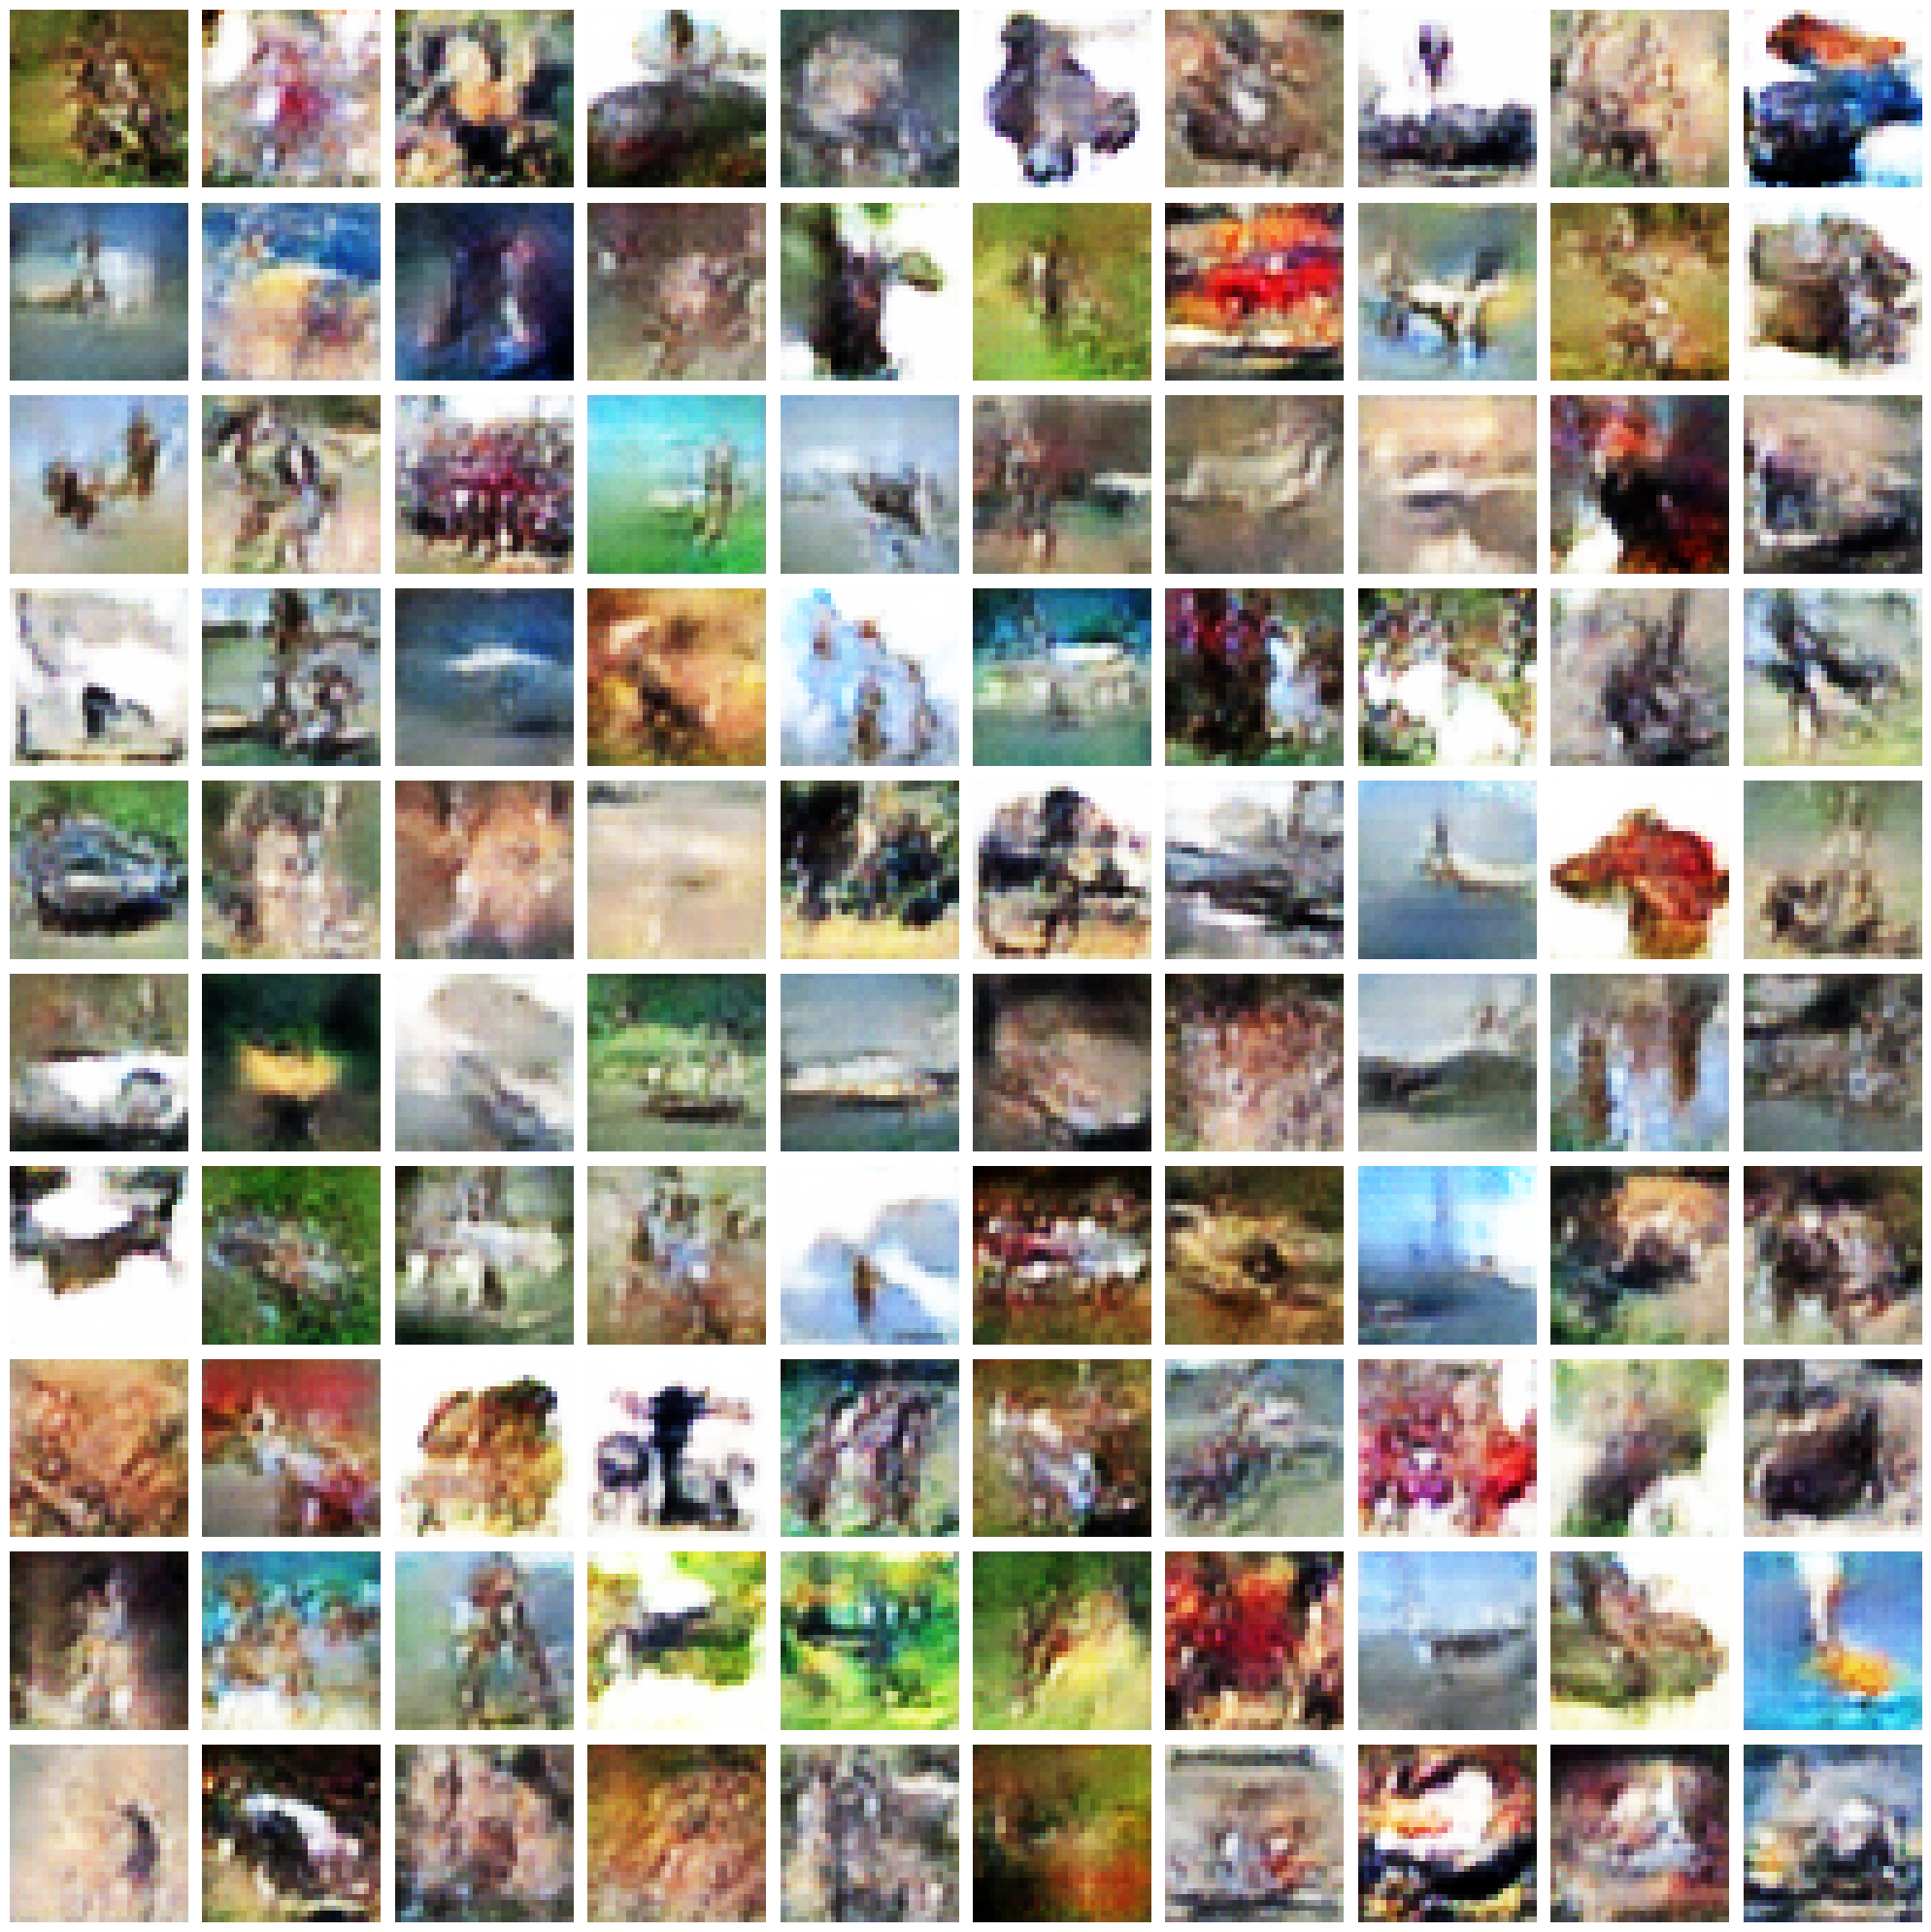

In [17]:
sample(gan_model.generator, num_samples=100, shape=(100, 1, 1), device=device, show=True)
pass

# VAE

In [4]:
class VAEModule(BaseModel):
    def __init__(self, latent_dim=128, lr=1e-3, beta=0.1):
        super().__init__()
        self.vae_model = VariationalAutoEncoder(latent_dim=latent_dim)
        self.latent_dim = latent_dim
        self.lr = lr
        self.beta = beta

        self.validation_z = torch.randn(40, latent_dim, device=self.device)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.vae_model.parameters(), lr=self.lr)
        return {"vae_optimizer": optimizer}

    @staticmethod
    def loss_function(outputs, targets, beta=0.1):
        recon_x, mu, logvar = outputs
        x = targets

        bce = bce_loss(recon_x.view(-1, 3 * 32 * 32), x.view(-1, 3 * 32 * 32))
        kld = kld_loss(mu, logvar)
        total_loss = bce + beta * kld
        return total_loss, bce, kld

    def training_step(self, batch, optimizers):
        imgs, _ = batch
        imgs = imgs.to(self.device)

        optimizer = optimizers["vae_optimizer"]

        # Forward pass
        outputs = self.vae_model(imgs)
        loss, bce, kld = self.loss_function(outputs, imgs, beta=self.beta)

        ssim = SSIMLoss()(imgs, outputs[0])

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return {"loss": loss.item(), "bce": bce.item(), "kld": kld.item(), "ssim": ssim.item()}

    def validation_step(self, batch, batch_idx):
        imgs, _ = batch
        imgs = imgs.to(self.device)

        # Forward pass
        outputs = self.vae_model(imgs)
        loss, bce, kld = self.loss_function(outputs, imgs, beta=self.beta)

        ssim = SSIMLoss()(imgs, outputs[0])

        val_output = {"loss": loss.item(), "bce": bce.item(), "kld": kld.item(), "ssim": ssim.item()}

        if batch_idx == 0:
            reconstructed_images = torchvision.utils.make_grid(torch.cat([imgs[:8], outputs[0][:8]], dim=0), nrow=8)
            sampled_imaged = torchvision.utils.make_grid(self.vae_model.decode(self.validation_z))
            val_output.update({
                "reconstruction_img": reconstructed_images,
                "sampling_img": sampled_imaged
            })

        return val_output


In [5]:
vae_model = VAEModule(latent_dim=128)

vae_trainer = Trainer(
    model=vae_model,
    data_module=cifar10_data_module,
    log_dir='./tensorboard/vae_logs',
    checkpoint_dir='./tensorboard/vae_checkpoints',
    device=device)

In [6]:
vae_trainer.train(num_epochs=10)

Epoch 0:
	Train Metrics = {'loss': 117893.016575, 'bce': 117858.4963125, 'kld': 345.2027937683105, 'ssim': 0.4592949793815613}
	Val Metrics = {'loss': 114065.46082553742, 'bce': 114014.88212828424, 'kld': 505.78696320163215, 'ssim': 0.36756615805777776}
	Best model saved at epoch 0 with loss=114065.460826
Epoch 0:
	Train Metrics = {'loss': 113721.206775, 'bce': 113669.0220375, 'kld': 521.8458334960937, 'ssim': 0.34109435901641844}
	Val Metrics = {'loss': 112858.83553941082, 'bce': 112805.74343152867, 'kld': 530.9227154968651, 'ssim': 0.318944970513605}
	Best model saved at epoch 1 with loss=112858.835539
Epoch 1:
	Train Metrics = {'loss': 112927.4071625, 'bce': 112875.683875, 'kld': 517.2325416503907, 'ssim': 0.3050007258415222}
	Val Metrics = {'loss': 112303.78623855494, 'bce': 112254.38098377787, 'kld': 494.05331362584593, 'ssim': 0.29265949604617564}
	Best model saved at epoch 2 with loss=112303.786239
Epoch 2:
	Train Metrics = {'loss': 112497.373825, 'bce': 112447.1875375, 'kld': 5

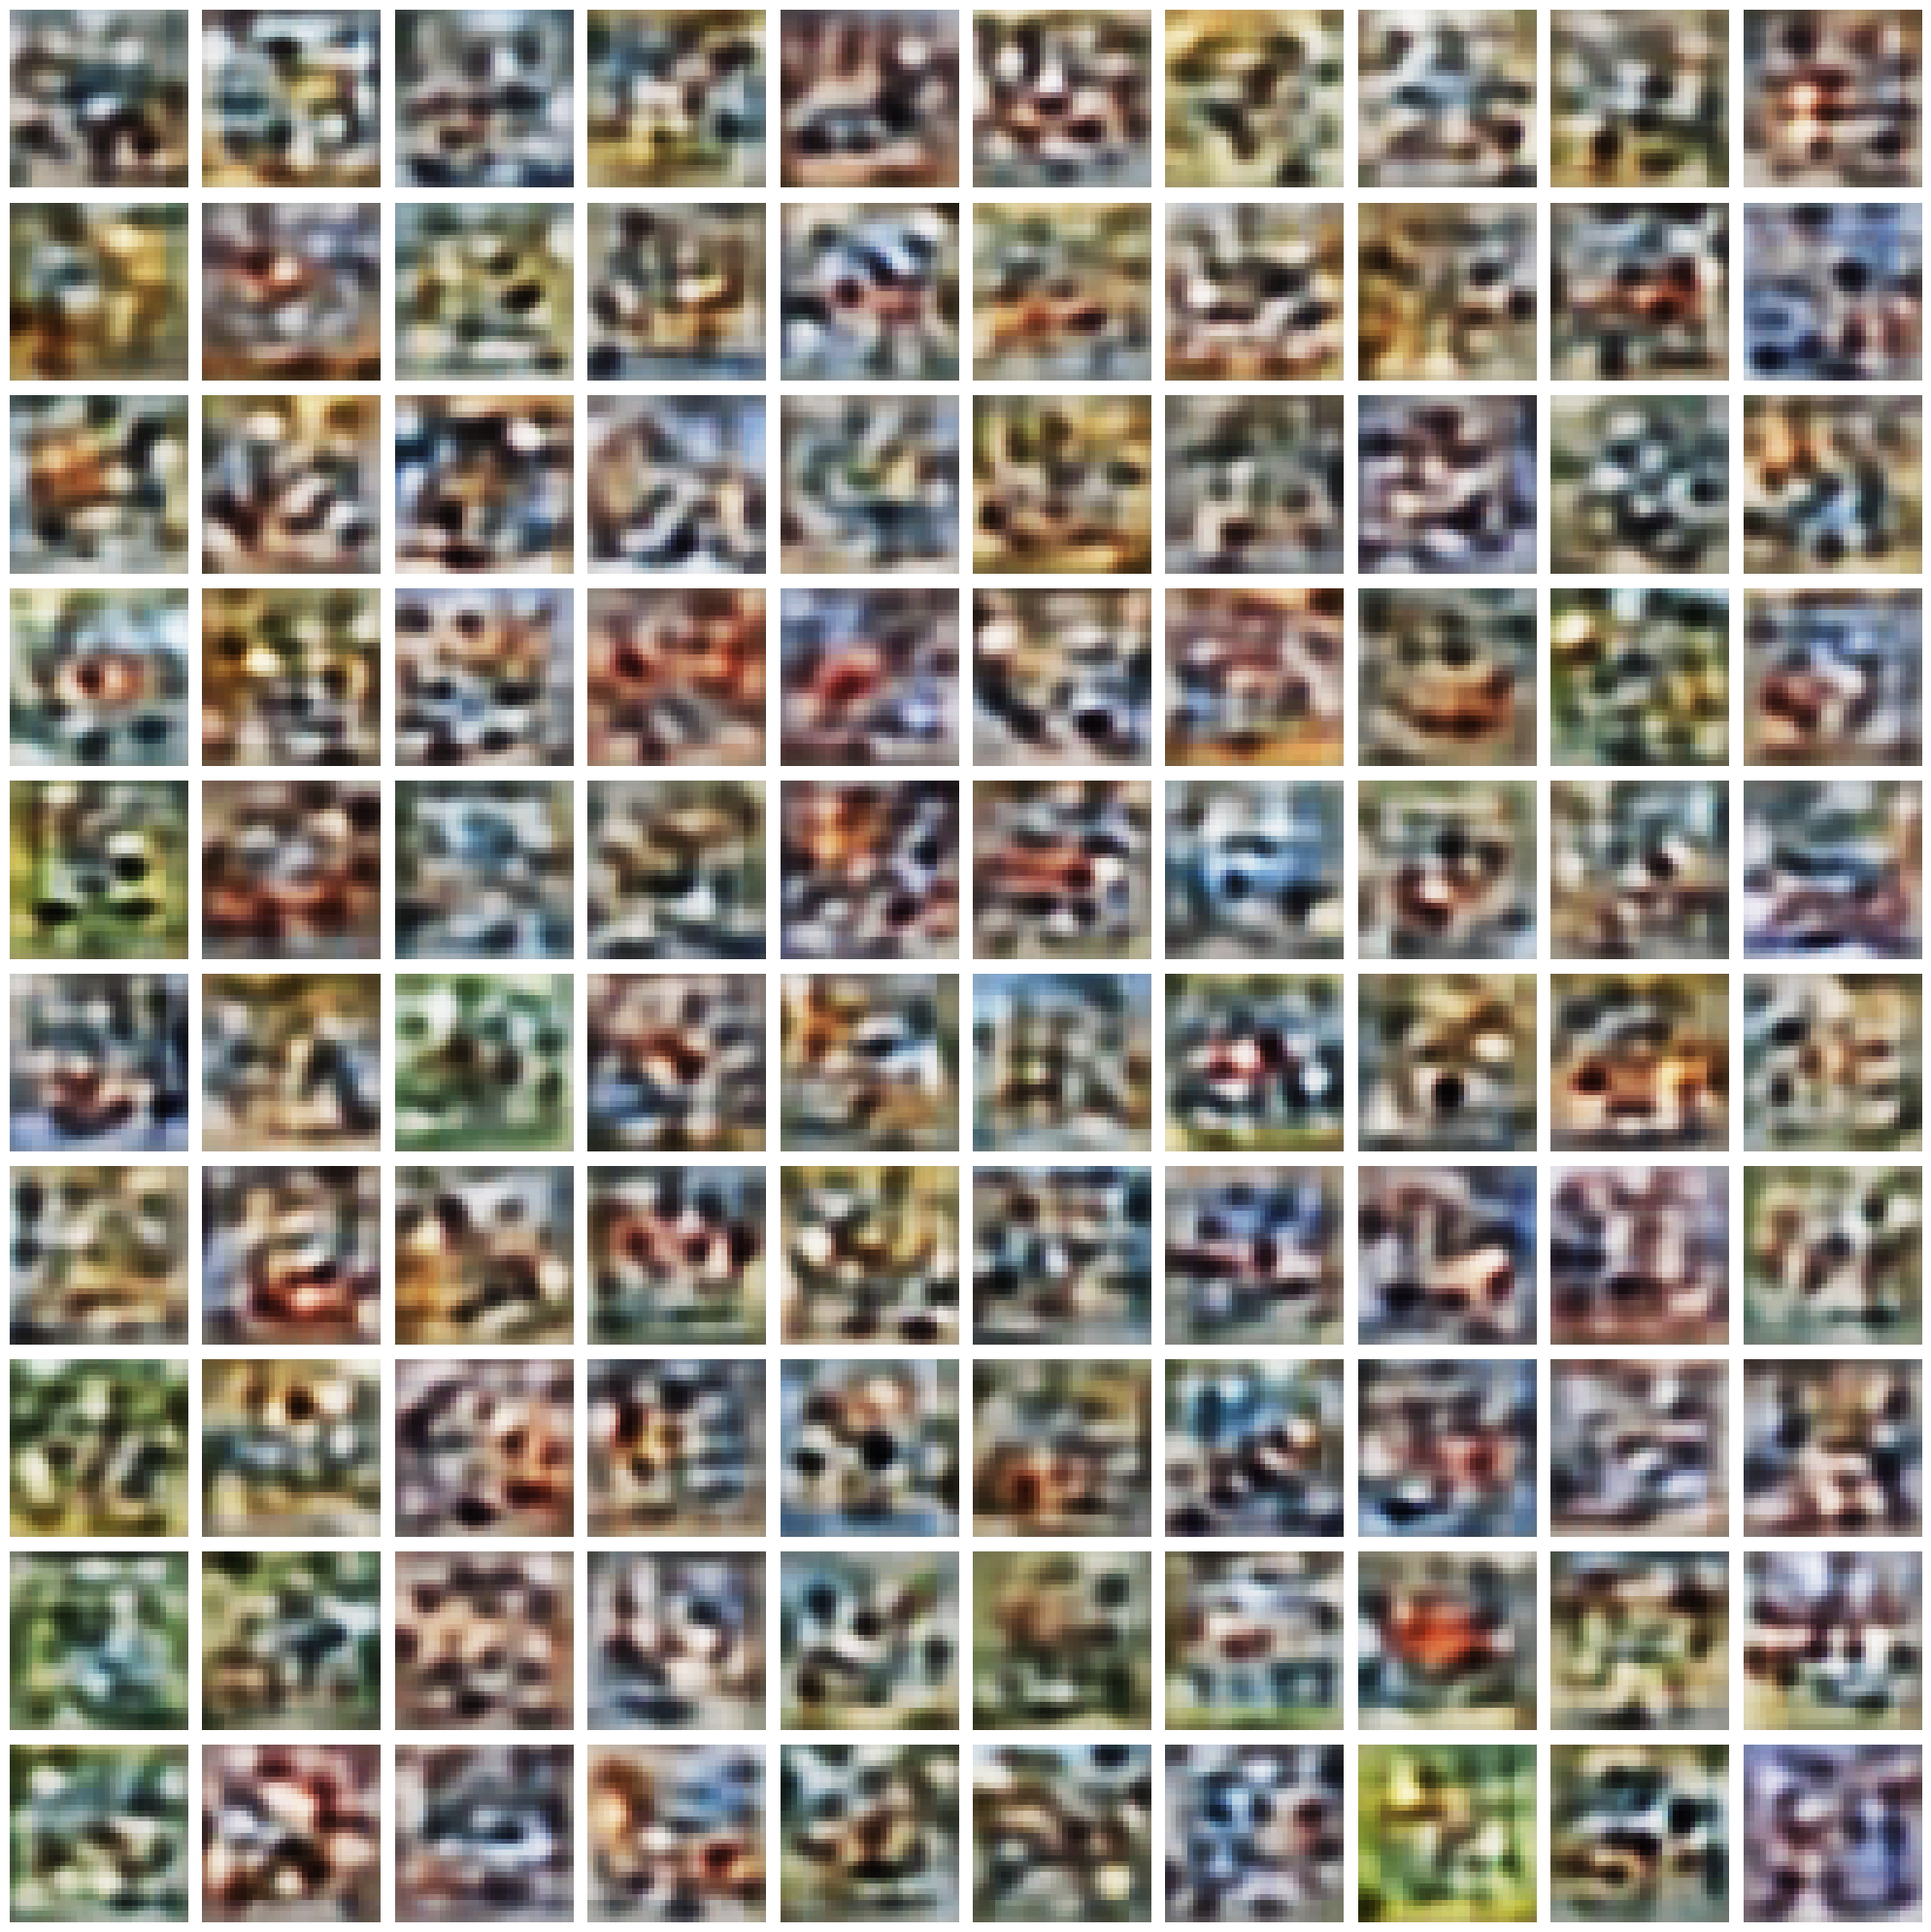

''

In [7]:
sample(vae_model.vae_model.decode, 100, shape=(128,), device=device, show=True)
_

# AE

In [14]:
class AEModule(BaseModel):
    def __init__(self, lr=1e-3):
        super().__init__()
        self.ae_model = AutoEncoder()
        self.lr = lr
        self.loss_function = mse_loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.ae_model.parameters(), lr=self.lr)
        return {"ae_optimizer": optimizer}

    def training_step(self, batch, optimizers):
        imgs, _ = batch
        imgs = imgs.to(self.device)

        optimizer = optimizers["ae_optimizer"]

        # Forward pass
        outputs = self.ae_model(imgs)

        loss = self.loss_function(outputs, imgs)
        ssim = SSIMLoss()(imgs, outputs)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return {"loss": loss, "ssim": ssim.item()}

    def validation_step(self, batch, batch_idx):
        imgs, _ = batch
        imgs = imgs.to(self.device)

        # Forward pass
        outputs = self.ae_model(imgs)

        loss = self.loss_function(outputs, imgs)
        ssim = SSIMLoss()(imgs, outputs)
        val_output = {"loss": loss, "ssim": ssim.item()}

        if batch_idx == 0:
            reconstructed_images = torchvision.utils.make_grid(torch.cat([imgs[:8], outputs[:8]], dim=0))
            val_output.update({
                "reconstruction_img": reconstructed_images,
            })

        return val_output


In [15]:
ae_model = AEModule(lr=5e-4)

ae_trainer = Trainer(
    model=ae_model,
    data_module=cifar10_data_module,
    log_dir='./tensorboard/ae_logs',
    checkpoint_dir='./tensorboard/ae_checkpoints',
    device=device)

In [16]:
ae_trainer.train(num_epochs=20)

Epoch 0:
	Train Metrics = {'loss': 0.022998657125234603}
	Val Metrics = {'loss': 0.012661559097943413}
	Best model saved at epoch 0 with loss=0.012662
Epoch 0:
	Train Metrics = {'loss': 0.011010135336220264}
	Val Metrics = {'loss': 0.009788866059937675}
	Best model saved at epoch 1 with loss=0.009789
Epoch 1:
	Train Metrics = {'loss': 0.008810060821473599}
	Val Metrics = {'loss': 0.008096330763570442}
	Best model saved at epoch 2 with loss=0.008096
Epoch 2:
	Train Metrics = {'loss': 0.00761710020750761}
	Val Metrics = {'loss': 0.007175135586387033}
	Best model saved at epoch 3 with loss=0.007175
Epoch 3:
	Train Metrics = {'loss': 0.006872707861661911}
	Val Metrics = {'loss': 0.006530060103625819}
	Best model saved at epoch 4 with loss=0.006530
Epoch 4:
	Train Metrics = {'loss': 0.006311516872048378}
	Val Metrics = {'loss': 0.006065843834476486}
	Best model saved at epoch 5 with loss=0.006066
Epoch 5:
	Train Metrics = {'loss': 0.005719447852671146}
	Val Metrics = {'loss': 0.005411887182

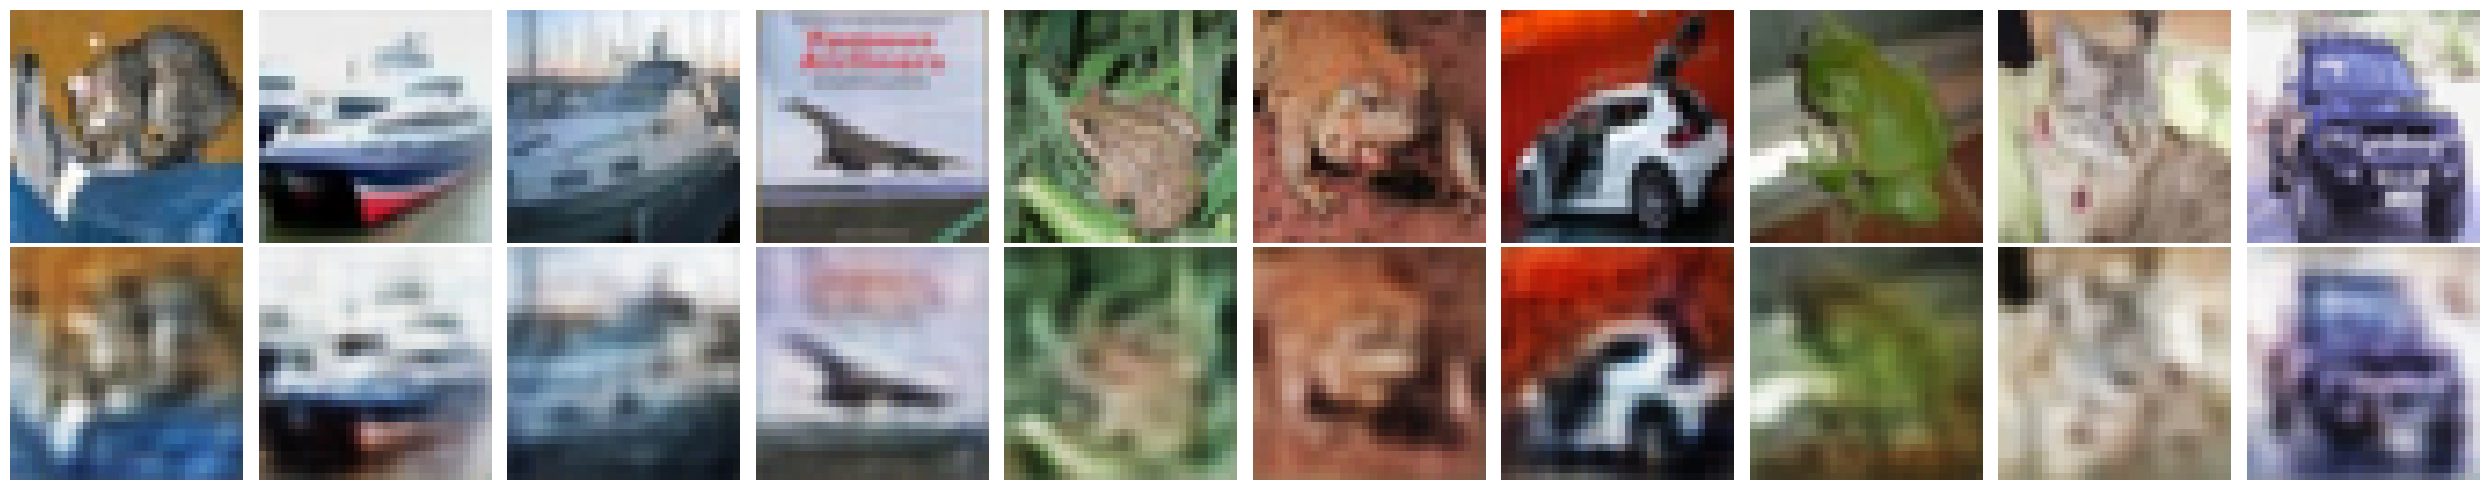

In [25]:
visualize_reconstructions(ae_model.ae_model, cifar10_data_module.test_dataloader(), device=device)

In [ ]:
'img'